Resnet Implementation

In [81]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import modal
from modal import Image

In [14]:
RANDOM = 69

In [15]:
# load and preprocess data
data = pd.read_csv('dataset/fer2013.csv')
width, height = 48, 48
datapoints = data['pixels'].tolist()
faces = []
for pixel_sequence in datapoints:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
emotions = data['emotion'].values

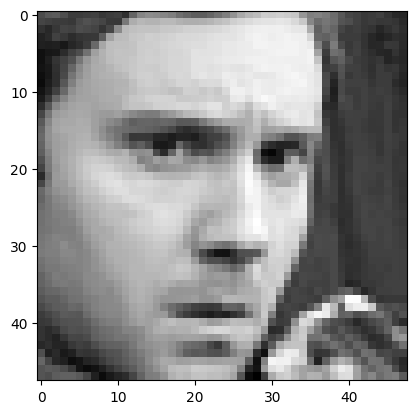

Emotion: angry


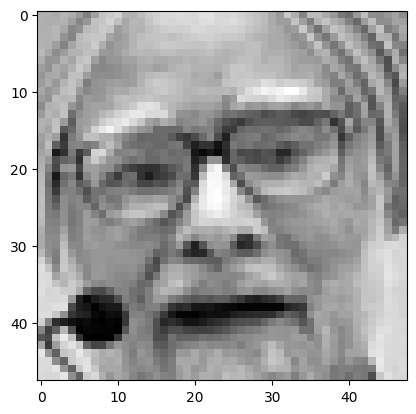

Emotion: angry


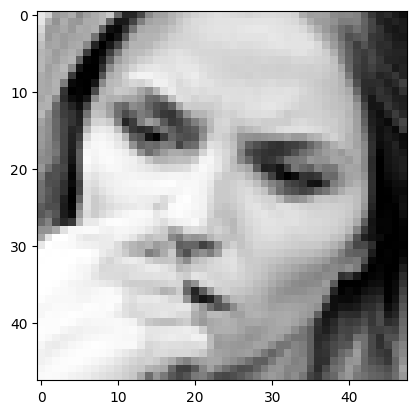

Emotion: fear


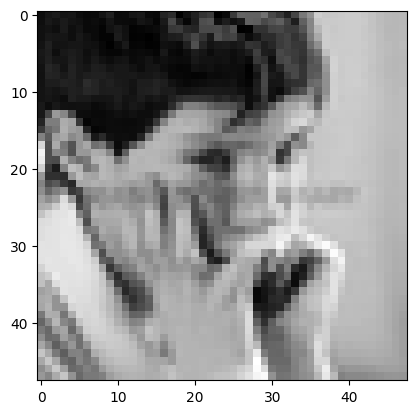

Emotion: sad


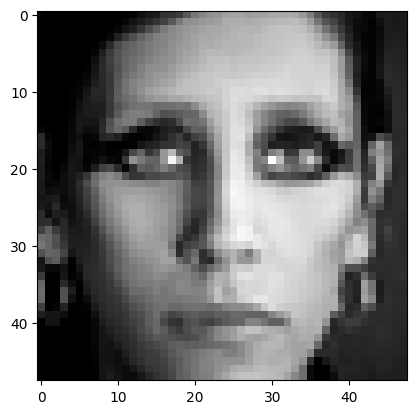

Emotion: neutral


In [16]:
emotion_labels = ["angry", "disgust", "fear", "happy", "sad", "suprise", "neutral"]
for i in range(5):
    plt.imshow(faces[i].squeeze(), cmap='gray')
    plt.show()

    print(f"Emotion: {emotion_labels[emotions[i]]}")

In [19]:
# config 
train_ratio = 0.8
eval_ratio  = 0.1
test_ratio  = 0.1

# First, split the data into training and remaining sets
x_train, x_rem, y_train, y_rem = train_test_split(faces, emotions, train_size=0.8, stratify=emotions, random_state=RANDOM)

# Then, split the remaining data into testing and evaluation sets
x_test, x_eval, y_test, y_eval = train_test_split(x_rem, y_rem, train_size=0.5, stratify=y_rem, random_state=RANDOM)

# We need to oversample minority classes to prevent bias in the model
unique_classes = np.unique(y_train)

# Group the dataset up by class
train_faces_by_class = [x_train[y_train == label] for label in unique_classes]
train_emotions_by_class = [y_train[y_train == label] for label in unique_classes]
eval_faces_by_class = [x_eval[y_eval == label] for label in unique_classes]
eval_emotions_by_class = [y_eval[y_eval == label] for label in unique_classes]

# The number of examples for the majority and minority class
train_max = max(len(face_class) for face_class in train_faces_by_class)
train_min = min(len(face_class) for face_class in train_faces_by_class)

print("Before oversampling:")
print(f"Train: {np.bincount(y_train)}")
print(f"Eval: {np.bincount(y_eval)}")

# Oversample the minority classes
oversampled_train_x = []
oversampled_train_y = []

def getResampleIndices(num_to_sample, class_len):
    samples = []
    sample_index = 0
    while num_to_sample > 0:
        if sample_index >= class_len:
            sample_index = 0
        samples.append(sample_index)
        sample_index += 1
        num_to_sample -= 1
    
    return samples

for face_class, emotion_class in zip(train_faces_by_class, train_emotions_by_class):
    num_to_sample = train_max - face_class.shape[0]

    resample_map = getResampleIndices(num_to_sample, face_class.shape[0])
    resampled_inputs = face_class[resample_map]
    resampled_labels = emotion_class[resample_map]

    final_faces = np.concatenate([face_class, resampled_inputs])
    final_emotions = np.concatenate([emotion_class, resampled_labels])

    oversampled_train_x.append(final_faces)
    oversampled_train_y.append(final_emotions)

# Put our oversampled dataset back together 
x_train = np.concatenate(oversampled_train_x)
y_train = np.concatenate(oversampled_train_y)

print("After oversampling:")
print(f"Train: {np.bincount(y_train)}")


Before oversampling:
Train: [3962  438 4097 7191 4861 3202 4958]
Eval: [496  54 512 899 608 400 620]
After oversampling:
Train: [7191 7191 7191 7191 7191 7191 7191]


In [20]:
# normalize and turn 2 tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

x_train = np.array([transform(x_train[i]) for i in range(x_train.shape[0])])
x_eval = np.array([transform(x_eval[i]) for i in range(x_eval.shape[0])])
x_test = np.array([transform(x_test[i]) for i in range(x_test.shape[0])])

print(f"Train: {x_train.shape}")
print(f"Eval: {x_eval.shape}")
print(f"Test: {x_test.shape}")

Train: (50337, 1, 48, 48)
Eval: (3589, 1, 48, 48)
Test: (3589, 1, 48, 48)


In [11]:
# step to make sure no data leakage :(
    
# Flatten the face data
X_train_flat = x_train.reshape(x_train.shape[0], -1)
X_test_flat = x_test.reshape(x_test.shape[0], -1)
X_eval_flat = x_eval.reshape(x_eval.shape[0], -1)

# Concatenate the datasets
X_combined = np.concatenate((X_train_flat, X_test_flat, X_eval_flat), axis=0)
dataset_labels = np.concatenate((np.full(X_train_flat.shape[0], 'train'),
                                 np.full(X_test_flat.shape[0], 'test'),
                                 np.full(X_eval_flat.shape[0], 'eval')))

# Find duplicate faces
unique_faces, face_counts = np.unique(X_combined, axis=0, return_counts=True)
duplicate_indices = np.where(face_counts > 1)[0]

# Analyze the duplicates
if len(duplicate_indices) > 0:
    print("Duplicates found:")
    for idx in duplicate_indices:
        duplicate_face = unique_faces[idx]
        duplicate_indices = np.where((X_combined == duplicate_face).all(axis=1))[0]
        duplicate_labels = dataset_labels[duplicate_indices]
        print(f"Duplicate face: {duplicate_face}")
        print(f"Original datasets: {duplicate_labels}")
else:
    print("No duplicates found.")
"""
the goddamn function is silly, it only checks duplicates
basically if the 'Original datasets:' part goes across train, test, eval
then you know ur stuff is fucked
otherwise ur good bro
happy coding
"""

KeyboardInterrupt: 

In [9]:
# i did not even out eval and test ... why are we? just gonna test over same pics, whats the point
print(np.bincount(y_eval))

[496  54 512 899 608 400 620]


In [21]:
# define data transformations
# train_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])
# ])

train_dataset = torch.utils.data.TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
eval_dataset = torch.utils.data.TensorDataset(torch.tensor(x_eval), torch.tensor(y_eval))


In [147]:
# GPU acceleration
stub = modal.Stub(name="resnet")

image = (
    Image.debian_slim(python_version="3.12.1")
    .pip_install(
        "torch==2.2.1",
        "torchvision==0.17.1",
    )
) 

@stub.function(
    gpu="any",
    image=image,
)
def train(train_loader, eval_loader, model, criterion, optimizer, meta_data=None):
    print("Entered train function...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device.type}")

    model.to(device)

    def run_epoch():
        model.train()

        total_loss = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss

        return total_loss / len(train_loader)

    def calculate_accuracy(loader):
        model.eval()

        correct = 0
        total_samples = 0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                correct += torch.sum(preds == labels)
                total_samples += inputs.size(0)

        return (correct, total_samples)
   
    if meta_data == None:
        meta_data = []
         
    for i in range(3):
        print("-"*25)

        epoch = len(meta_data)
        print(f"Epoch: {epoch}")

        eval_correct, eval_total = calculate_accuracy(eval_loader)
        train_correct, train_total = calculate_accuracy(train_loader)

        train_accuracy = train_correct.to('cpu') / train_total
        eval_accuracy = eval_correct.to('cpu') / eval_total

        print(f"Train: {train_correct}/{train_total} | {train_accuracy}")
        print(f"Eval: {eval_correct}/{eval_total} | {eval_accuracy}")

        loss = run_epoch()
        print(f"Loss: {loss}")

        meta_data.append({'epoch': epoch, 'train': float(train_accuracy), 'eval': float(eval_accuracy), 'loss': float(loss)})

        epoch += 1
    
    model.to('cpu')

    print(f"Saving model checkpoint at {len(meta_data)}th epoch")

    return model, meta_data

In [140]:
# define the model
model = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=7)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

In [141]:
# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=len(eval_dataset), shuffle=False)

if os.path.exists('model_state_dict.pth') and os.path.exists('meta_data.pkl'):
    model.load_state_dict(torch.load("model_state_dict.pth", map_location=torch.device('cpu')))

    with open('meta_data.pkl', 'rb') as file:
        loaded_meta_data = pickle.load(file)

        with stub.run():
            model, meta_data = train.remote(train_loader, eval_loader, model, criterion, optimizer, loaded_meta_data)

            model.to('cpu')

            torch.save(model.state_dict(), 'model_state_dict.pth')
            with open('meta_data.pkl', 'wb') as file:
                pickle.dump(meta_data, file)
else:
    print("Training model...") # if want to retrain, change path name or delete file
    with stub.run():
        model, meta_data = train.remote(train_loader, eval_loader, model, criterion, optimizer)

        model.to('cpu')

        torch.save(model.state_dict(), 'model_state_dict.pth')
        with open('meta_data.pkl', 'wb') as file:
            pickle.dump(meta_data, file)


/Users/imenkedir/miniforge3/envs/EmotionRecML/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

✓ Initialized. View run at https://modal.com/imenkedir/apps/ap-shc3cNPNQkWk2vGAzbPAp3

✓ Created objects.
└── 🔨 Created train.

Entered train function...


Device: cuda


-------------------------
Epoch: 12


Train: 42393/50337 | 0.8421837091445923


Eval: 2000/3589 | 0.5572583079338074


Loss: 0.47936469316482544


-------------------------


Epoch: 13


Train: 42395/50337 | 0.8422234058380127


Eval: 2003/3589 | 0.5580942034721375


Loss: 0.47675782442092896
-------------------------
Epoch: 14


Train: 42297/50337 | 0.8402765393257141


Eval: 1998/3589 | 0.5567010045051575


Loss: 0.476594477891922


Saving model checkpoint at 15th epoch


Stopping app - local entrypoint completed.


✓ App completed. View run at https://modal.com/imenkedir/apps/ap-shc3cNPNQkWk2vGAzbPAp3

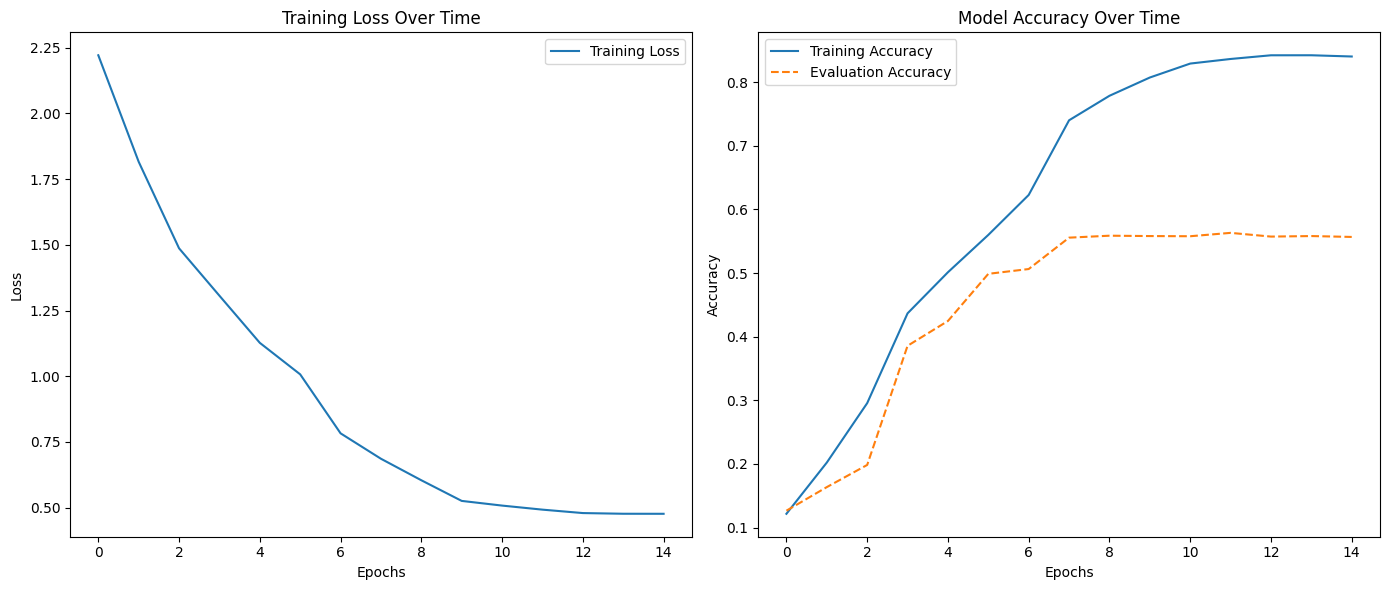

In [144]:
with open('meta_data.pkl', 'rb') as file:
    loaded_meta_data = pickle.load(file)

    # Assuming 'meta_data' is the list returned by your training function
    epochs = [entry['epoch'] for entry in loaded_meta_data]
    losses = [entry['loss'] for entry in loaded_meta_data]
    train_accuracies = [entry['train'] for entry in loaded_meta_data]
    eval_accuracies = [entry['eval'] for entry in loaded_meta_data]

    # Plotting the training loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    # Plotting the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, eval_accuracies, label='Evaluation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [171]:
@stub.function(
    gpu="any",
    image=image,
)
def learned_representation(loader, model):
    print("Entered forward function")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            x = model.conv1(inputs)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)

            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)

            x = model.avgpool(x)
            x = torch.flatten(x, 1)

            print("Leaving remote")
            return (x.to("cpu"))


In [172]:
model = models.ResNet(block=models.resnet.BasicBlock, layers=[2, 2, 2, 2], num_classes=7)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

if os.path.exists('model_state_dict.pth') and os.path.exists('meta_data.pkl'):
    print("Loaded model")
    model.load_state_dict(torch.load("model_state_dict.pth", map_location=torch.device('cpu')))

data_loader = DataLoader(eval_dataset, len(eval_dataset), shuffle=False)
with stub.run():
    eta = learned_representation.remote(data_loader, model)

    print(eta.shape)

/Users/imenkedir/miniforge3/envs/EmotionRecML/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

✓ Initialized. View run at https://modal.com/imenkedir/apps/ap-6MfkbIaUBLBJT3lI5Qq35A

Loaded model


✓ Created objects.
├── 🔨 Created train.
├── 🔨 Created foo.
└── 🔨 Created learned_representation.

Entered forward function


cuda


Leaving remote


torch.Size([3589, 512])

Stopping app - local entrypoint completed.


✓ App completed. View run at https://modal.com/imenkedir/apps/ap-6MfkbIaUBLBJT3lI5Qq35A

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the features
pca_features = PCA(n_components=2).fit_transform(features.reshape(features.shape[0], -1))
tsne_features = TSNE(n_components=2).fit_transform(features.reshape(features.shape[0], -1))

# Visualize the t-SNE or PCA results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE Visualization')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
plt.title('PCA Visualization')
plt.show()